# With lagged climate data indicators 
### Climate data impact comes usually after weeks or months. Hence good to apply the lagged climate data influence in to considration 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Load datasets
kal_data = pd.read_excel('/Users/berhe/Desktop/ka-project/KA_linelist/ll_ka.xlsx')                              # Linelist data 
climate_data = pd.read_csv('/Users/berhe/Desktop/ka-project/Temp-rain-humid/NASA-Temp-perc-humid.csv')          # Rainfall data can e dropped
ndvi_data_16d = pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/MODIS_NDVI_Lankien.csv')              # biweekly NDVI data                     
lst_data = pd.read_csv('/Users/berhe/Desktop/ka-project/MODIS_LST_Dataset/MODIS_LST_Lankien.csv')               # land surface temprature 
perc_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Precipitation_Data/SPI_Lankien.csv')                    # better quality
soil_mois_data =pd.read_csv('/Users/berhe/Desktop/ka-project/soil_moisture_data.csv')
radiation_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Solar_radiation_Dataset/radiation_Lankien.csv')
wind_data =pd.read_csv('/Users/berhe/Desktop/ka-project/Wind_Data_Dataset/wind_Lankien_20250304.csv')
ndvi_data_5d =pd.read_csv('/Users/berhe/Desktop/ka-project/NDVI_Dataset/fiveday_NDVI_Lankien.csv')
evi_data_16d =pd.read_csv('/Users/berhe/Desktop/ka-project/EVI/EVI_16day_Lankien.csv')
flood_cover = pd.read_csv("flood_cover/lankien_flood_timeseries_2015_2024.csv")

# Flood cover data 
flood_cover["date"] = pd.to_datetime(flood_cover["date"]).dt.date
flood_cover["date"] = pd.to_datetime(flood_cover["date"])

# keep only the maximumof the flooded_area_m2 value
flood_cover = flood_cover.groupby("date", as_index=False).max()

# rename the 5d NDVI column to NDVI_5d
ndvi_data_5d.rename(columns={"NDVI": "NDVI_5d"}, inplace=True)

# Convert date columns
kal_data["date"] = pd.to_datetime(kal_data["date"])
climate_data["date"] = pd.to_datetime(climate_data["date"])
ndvi_data_16d["Date"] = pd.to_datetime(ndvi_data_16d["Date"])
lst_data["Date"] =pd.to_datetime(lst_data["Date"])
perc_data["Date"] =pd.to_datetime(perc_data["Date"])
soil_mois_data["Date"] =pd.to_datetime(soil_mois_data["Date"])
radiation_data["date"] =pd.to_datetime(radiation_data["date"])
wind_data["date"] =pd.to_datetime(wind_data["date"])
ndvi_data_5d["Date"] =pd.to_datetime(ndvi_data_5d["Date"])
evi_data_16d["date"] =pd.to_datetime(evi_data_16d["date"])

# Rename NDVI date column to match others
ndvi_data_16d.rename(columns={"Date": "date"}, inplace=True)
ndvi_data_5d.rename(columns={"Date": "date"}, inplace=True)
lst_data.rename(columns={"Date": "date"}, inplace=True)
perc_data.rename(columns={"Date": "date"}, inplace=True)
soil_mois_data.rename(columns={"Date": "date"}, inplace=True)

# Aggregate KA cases per day
ka_cases_daily = kal_data.groupby("date").size().reset_index(name="ka_cases")

# Merge datasets
merged_df = pd.merge(ka_cases_daily, climate_data, on= "date", how = "right")
merged_df = merged_df.merge(ndvi_data_16d, on="date", how= "left")                # Left join keeps all climate data
merged_df = merged_df.merge(ndvi_data_5d, on="date", how= "left")                # Left join keeps all climate data
merged_df =merged_df.merge(lst_data, on = "date", how = "left")
merged_df =merged_df.merge(perc_data, on = "date", how = "left")
merged_df =merged_df.merge(soil_mois_data, on = "date", how = "left")
merged_df =merged_df.merge(radiation_data, on = "date", how = "left")
merged_df =merged_df.merge(wind_data, on = "date", how = "left")
merged_df =merged_df.merge(evi_data_16d, on = "date", how = "left")
merged_df =merged_df.merge(flood_cover, on = "date", how = "left")


# handle the missing values

merged_df["ka_cases"].fillna(0, inplace=True)
merged_df["NDVI"] = merged_df["NDVI"].fillna(method="ffill")
merged_df["Precipitation"] = merged_df["Precipitation"].fillna(method="ffill")
merged_df["SPI"] = merged_df["SPI"].fillna(method="ffill")
merged_df["LST_Day_1km"] = merged_df["LST_Day_1km"].fillna(method="ffill")
merged_df["humidity"] = merged_df["humidity"].fillna(method="ffill")
merged_df["Soil_Moisture"] = merged_df["Soil_Moisture"].fillna(method="ffill")
merged_df["NDVI_5d"] = merged_df["NDVI_5d"].fillna(method="ffill")
merged_df["EVI"] = merged_df["EVI"].fillna(method="ffill")
merged_df["flooded_area_m2"] = merged_df["flooded_area_m2"].fillna(method="ffill")

# Drop rows where 'LST_Day_1km' is missing
merged_df = merged_df.dropna(subset=["LST_Day_1km"])
merged_df = merged_df.dropna(subset=["Soil_Moisture"])
merged_df = merged_df.dropna(subset=["NDVI_5d"])

# filter data to only the period where we have KA cases

# Filter for dates greater than or equal to 2015-11-01
merged_df = merged_df[merged_df["date"] >= "2015-11-01"]
merged_df = merged_df[merged_df["date"] <= "2022-04-05"]

# Display the first few rows of the merged dataset
merged_df.head()

# Check if there are still any missing values
print(merged_df.isnull().sum())

# save the raw data 
merged_df.to_csv("merged_df.csv")

# Feature selection
features = ["temp_mean", "temp_min", "temp_max", "humidity", "NDVI", "NDVI_5d", "Precipitation", "SPI", "LST_Day_1km", "Soil_Moisture", "solar_radiation", "wind_speed_10m", "wind_direction_10m","wind_speed_50m", "wind_direction_50m","EVI", "flooded_area_m2"]
X = merged_df[features]
y = merged_df["ka_cases"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
## Create lagged features (4-week lag)
#for lag in range(1, 60):  # 90-day lag
#    for col in features:
#        merged_df[f"{col}_lag{lag}"] = merged_df[col].shift(lag)
#
## Drop missing values after lagging
#merged_df.dropna(inplace=True)
#
## Update X after adding lags
#lag_features = [col for col in merged_df.columns if "lag" in col]  # All new lag features
#X = merged_df[lag_features]
#y = merged_df["ka_cases"]
#
## Split the new dataset
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
# Create a dictionary to store lagged features
lagged_data = {}

for lag in range(1, 90):  # 60-day lag
    for col in features:
        lagged_data[f"{col}_lag{lag}"] = merged_df[col].shift(lag)

# Convert to DataFrame and concatenate all at once
lagged_df = pd.DataFrame(lagged_data)
merged_df = pd.concat([merged_df, lagged_df], axis=1)

# Drop missing values after lagging
merged_df.dropna(inplace=True)

# Update feature set
lag_features = [col for col in merged_df.columns if "lag" in col]
X = merged_df[lag_features]
y = merged_df["ka_cases"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 1: Feature Selection using Lasso Regression

In [ ]:

from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Standardize features (Lasso is sensitive to scale)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lasso regression with cross-validation to find the best alpha
lasso = LassoCV(cv=5, random_state=42, max_iter=5000)  
lasso.fit(X_train_scaled, y_train)

# Get selected features (non-zero coefficients)
selected_features = X_train.columns[lasso.coef_ != 0].to_list()
print(f"Selected {len(selected_features)} features out of {X_train.shape[1]}")

# Reduce dataset to selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Re-scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

# Convert back to DataFrame (optional, useful for further analysis)
X_train_final = pd.DataFrame(X_train_selected_scaled, columns=selected_features)
X_test_final = pd.DataFrame(X_test_selected_scaled, columns=selected_features)

print("Final dataset prepared with selected features.")


In [ ]:
X_train_final

### Step 2: Dimensionality Reduction using PCA
If the feature space is still large after Lasso, we can apply PCA to reduce correlated features while preserving variance.

In [9]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]} using PCA.")


Reduced features from 1513 to 21 using PCA.


# Step 3: Dimesionality reduction suing the LASSO and then PCA

In [14]:
from sklearn.decomposition import PCA

# Apply PCA to retain 95% of variance
pca = PCA(n_components=0.95, random_state=42)
X_train_lasso_pca = pca.fit_transform(X_train_final)
X_test_lasso_pca = pca.transform(X_test_final)

print(f"Reduced features from {X_train.shape[1]} to {X_train_pca.shape[1]} using PCA.")


Reduced features from 1513 to 21 using PCA.


## Test

In [15]:
# Test variables selected using LASSO

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_final, y_train)

# Predictions
y_pred = rf_model.predict(X_test_final)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance: MSE = {mse:.2f}, R² = {r2:.3f}")


Model Performance: MSE = 14.12, R² = 0.212


In [16]:
# Test variables selected using PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Predictions
y_pred = rf_model.predict(X_test_pca)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance: MSE = {mse:.2f}, R² = {r2:.3f}")


Model Performance: MSE = 12.70, R² = 0.291


Lasso selectd variable: RF Model Performance: MSE = 14.10, R² = 0.213
PCA selected variables: RF Model Performance: MSE = 12.70, R² = 0.291

In [13]:
## Define models
#models = {
#    "Linear Regression": LinearRegression(),
#    "Lasso Regression": Lasso(alpha=0.01, max_iter=5000),
#    "Elastic Net": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000),
#    "Bayesian Ridge": BayesianRidge(),
#    "Theil-Sen Regressor": TheilSenRegressor(),
#    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
#    "Extra Trees": ExtraTreesRegressor(n_estimators=100, random_state=42),
#    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
#    "XGBoost": XGBRegressor(n_estimators=100, random_state=42),
#    "CatBoost": CatBoostRegressor(iterations=100, depth=6, learning_rate=0.1, random_seed=42, verbose=0),
#    "LGBM": LGBMRegressor(n_estimators=100, random_state=42),
#    "Gaussian Process": GaussianProcessRegressor() if len(X_train) < 500 else None,  # Only for small datasets
#    "Support Vector Machine": SVR(kernel='rbf'),
#    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=20),
#    "Multi-Layer Perceptron": MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)
#}
#
## Models that require scaling
#models_requiring_scaling = ["Support Vector Machine", "Elastic Net", "Lasso Regression", 
#                            "Ridge Regression", "Multi-Layer Perceptron", "Gaussian Process"]
#
## Store results
#results = []
#
#plt.figure(figsize=(18, 12))
#
#for idx, (name, model) in enumerate(models.items(), 1):
#    if model is None:
#        continue  # Skip Gaussian Process for large datasets
#
#    # Apply scaling where necessary
#    X_train_input = X_train_pca if name in models_requiring_scaling else X_train_selected_scaled
#    X_test_input = X_test_pca if name in models_requiring_scaling else X_test_selected_scaled
#
#    # Train the model
#    if name == "XGBoost":
#        model.fit(X_train_input, y_train, eval_set=[(X_test_input, y_test)], verbose=False)
#    else:
#        model.fit(X_train_input, y_train)
#
#    # Predict
#    y_pred = model.predict(X_test_input)
#
#    # Evaluate performance
#    mse = mean_squared_error(y_test, y_pred)
#    rmse = np.sqrt(mse)
#    r2 = r2_score(y_test, y_pred)
#
#    # Store results
#    results.append({"Model": name, "MSE": mse, "RMSE": rmse, "R² Score": r2})
#
#    # Scatter Plot (Actual vs. Predicted)
#    plt.subplot(4, 4, idx)
#    plt.scatter(y_test, y_pred, alpha=0.5, color='blue', s=10)
#    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Perfect fit line
#    plt.title(f"{name}")
#    plt.xlabel("Actual")
#    plt.ylabel("Predicted")
#
#plt.tight_layout()
#plt.show()
#
## Convert to DataFrame for easy comparison
#results_df = pd.DataFrame(results).sort_values(by="R² Score", ascending=False)
#
## Display results
#print(results_df)
#
## Bar plot for RMSE comparison
#plt.figure(figsize=(12, 6))
#plt.barh(results_df["Model"], results_df["RMSE"], color='skyblue')
#plt.xlabel("RMSE")
#plt.title("Model Performance Comparison (Lower RMSE is Better)")
#plt.gca().invert_yaxis()  # Best models on top
#plt.show()


# Optimising/Hyperparameter tunning (tree based modles)

In [ ]:
#from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
#from lightgbm import LGBMRegressor  
#from sklearn.preprocessing import StandardScaler
#import numpy as np
#import pandas as pd
#from sklearn.metrics import r2_score
#
## scalled parameters 
#
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)
#
## Split data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
#
## Define better performing models
#models = {
#    "Random Forest": RandomForestRegressor(),
#    "Extra Trees": ExtraTreesRegressor(),
#    "Gradient Boosting": GradientBoostingRegressor(),
#    "XGBoost": XGBRegressor(),
#    "CatBoost": CatBoostRegressor(verbose=0),  # ✅ Fixed missing comma
#    "LGBM": LGBMRegressor()  # ✅ Correct spelling & added model
#}
#
## Define hyperparameter grids for each model
#param_grids = {
#    "Random Forest": {
#        "n_estimators": [50, 100, 200],
#        "max_depth": [10, 20, None],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4],
#        "bootstrap": [True, False]
#    },
#    "Extra Trees": {
#        "n_estimators": [50, 100, 200],
#        "max_depth": [10, 20, None],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4]
#    },
#    "Gradient Boosting": {
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [3, 4, 5],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4]
#    },
#    "XGBoost": {
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [3, 4, 5],
#        "min_child_weight": [1, 3, 5],
#        "subsample": [0.8, 1.0],
#        "colsample_bytree": [0.8, 1.0]
#    },
#    "CatBoost": {
#        "iterations": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "depth": [4, 6, 8],
#        "l2_leaf_reg": [1, 3, 5]
#    },
#    "LGBM": {  # ✅ Added hyperparameter grid for LGBM
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [-1, 5, 10],  # -1 means no limit
#        "num_leaves": [20, 31, 40],
#        "min_child_samples": [5, 10, 20]
#    }
#}
#
## Store model results
#results = []
#best_models = {}
#
## Perform Randomized Search for each model
#for name, model in models.items():
#    print(f"🔍 Optimizing {name}...")
#
#    if name in param_grids and param_grids[name]:  # Skip tuning Bayesian Ridge
#        search = RandomizedSearchCV(
#            model, param_distributions=param_grids[name], 
#            n_iter=10, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, random_state=42
#        )
#        search.fit(X_train, y_train)
#        best_model = search.best_estimator_
#        best_params = search.best_params_
#    else:
#        model.fit(X_train, y_train)
#        best_model = model
#        best_params = "Default"
#
#    # Store best model
#    best_models[name] = best_model
#
#    # Evaluate optimized model on the test set
#    y_pred = best_model.predict(X_test)
#    mse = np.mean((y_test - y_pred) ** 2)
#    rmse = np.sqrt(mse)
#    r2 = r2_score(y_test, y_pred)
#
#    results.append({
#        "Model": name,
#        "Best Parameters": best_params,
#        "Optimized MSE": mse,
#        "Optimized RMSE": rmse,
#        "R2": r2
#    })
#
## Convert to DataFrame for easy comparison
#results_df = pd.DataFrame(results)
#
## Display results
#print("\n🏆 Model Performance Comparison:")
#print(results_df)


### Five fold cross validating fitting 

In [ ]:
#from sklearn.model_selection import train_test_split, RandomizedSearchCV
#from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
#from xgboost import XGBRegressor
#from catboost import CatBoostRegressor
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error, r2_score
#from sklearn.metrics import mean_absolute_percentage_error
#import numpy as np
#import pandas as pd
#
## Feature Scaling (Only for non-tree models)
#scaler = StandardScaler()
#
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)
#
#tree_models = ["Random Forest", "Extra Trees", "Gradient Boosting", "XGBoost", "CatBoost"]
#
## Define models
#models = {
#    "Random Forest": RandomForestRegressor(),
#    "Extra Trees": ExtraTreesRegressor(),
#    "Gradient Boosting": GradientBoostingRegressor(),
#    "XGBoost": XGBRegressor(),
#    "CatBoost": CatBoostRegressor(verbose=0),
#    "LGBM": LGBMRegressor()                                # ✅ Correct spelling & added model
#}
#
## Define hyperparameter grids
#param_grids = {
#    "Random Forest": {
#        "n_estimators": [50, 100, 200],
#        "max_depth": [10, 20, None],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4],
#        "bootstrap": [True, False]
#    },
#    "Extra Trees": {
#        "n_estimators": [50, 100, 200],
#        "max_depth": [10, 20, None],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4],
#        "bootstrap": [True, False]
#    },
#    "Gradient Boosting": {
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [3, 4, 5],
#        "min_samples_split": [2, 5, 10],
#        "min_samples_leaf": [1, 2, 4]
#    },
#    "XGBoost": {
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [3, 4, 5],
#        "min_child_weight": [1, 3, 5],
#        "subsample": [0.8, 1.0],
#        "colsample_bytree": [0.8, 1.0]
#    },
#    "CatBoost": {
#        "iterations": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "depth": [4, 6, 8],
#        "l2_leaf_reg": [1, 3, 5]
#    },
#    "LGBM": {  # ✅ Added hyperparameter grid for LGBM
#        "n_estimators": [50, 100, 200],
#        "learning_rate": [0.05, 0.1, 0.2],
#        "max_depth": [-1, 5, 10],  # -1 means no limit
#        "num_leaves": [20, 31, 40],
#        "min_child_samples": [5, 10, 20]
#    }
#}
#
## Store model results
#results = []
#best_models = {}
#
#for name, model in models.items():
#    print(f"🔍 Optimizing {name}...")
#    
#    # Use scaled data for non-tree models
#    X_train_used = X_train_scaled if name not in tree_models else X_train
#    X_test_used = X_test_scaled if name not in tree_models else X_test
#
#    if name in param_grids and param_grids[name]:
#        search = RandomizedSearchCV(
#            model, param_distributions=param_grids[name], 
#            n_iter=20, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1, random_state=42
#        )
#        search.fit(X_train_used, y_train)
#        best_model = search.best_estimator_
#        best_params = search.best_params_
#    else:
#        model.fit(X_train_used, y_train)
#        best_model = model
#        best_params = "Default"
#
#    best_models[name] = best_model
#    
#    # Evaluate
#    y_pred = best_model.predict(X_test_used)
#    mse = mean_squared_error(y_test, y_pred)
#    rmse = np.sqrt(mse)
#    r2 = r2_score(y_test, y_pred)
#    mape = mean_absolute_percentage_error(y_test, y_pred) 
#    smape_value = smape(y_test, y_pred)  # ✅ Added SMAPE
#
#    results.append({
#        "Model": name,
#        "Best Parameters": best_params,
#        "Optimized MSE": mse,
#        "Optimized RMSE": rmse,
#        "Optimized MAPE": mape,          # ✅ Include MAPE
#        "Optimized SMAPE": smape_value,  # ✅ Include SMAPE
#        "R²": r2
#    })
#
## Convert to DataFrame for easy comparison
#results_df = pd.DataFrame(results).sort_values(by="Optimized RMSE")
#
## Display results
#print("\n🏆 Model Performance Comparison:")
#print(results_df[["Model", "Optimized RMSE", "Optimized MAPE", "Optimized SMAPE", "R²"]])  # ✅ Include MAPE & SMAPE

In [ ]:
#rt matplotlib.pyplot as plt
#rt seaborn as sns
#rt pandas as pd
#
#sure date column is in datetime format
#ed_df["date"] = pd.to_datetime(merged_df["date"])
#
#erate over all the best models
#name, model in best_models.items():
#print(f"\n📊 Plotting results for {name}...\n")
#
## Use scaled test data for non-tree models
#X_test_used = X_test_scaled if name not in tree_models else X_test
#y_pred = model.predict(X_test_used)
#residuals = y_test - y_pred
#
#
## 1️⃣ **Actual vs. Predicted Scatter Plot**
#plt.figure(figsize=(6, 6))
#sns.scatterplot(x=y_test.values, y=y_pred, alpha=0.7)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")  # Ideal line
#plt.xlabel("Actual Cases")
#plt.ylabel("Predicted Cases")
#plt.title(f"{name} - Actual vs. Predicted")
#plt.grid(True)
#plt.show()
#
## 2️⃣ **Residual Distribution**
#plt.figure(figsize=(6, 4))
#sns.histplot(residuals, bins=20, kde=True, color="blue")
#plt.axvline(0, color='red', linestyle='--')
#plt.xlabel("Residuals (Prediction Errors)")
#plt.ylabel("Frequency")
#plt.title(f"{name} - Residual Distribution")
#plt.grid(True)
#plt.show()
#
## 3️⃣ **Time Series Plot: Actual vs. Predicted**
#plt.figure(figsize=(12, 5))
#y_test_sorted = y_test.sort_index()
#y_pred_sorted = pd.Series(y_pred, index=y_test.index)
#
#plt.plot(merged_df.loc[y_test.index, "date"], y_test_sorted, label="Actual", marker="o", linestyle="-", markersize=3)
#plt.plot(merged_df.loc[y_test.index, "date"], y_pred_sorted, label="Predicted", marker="s", linestyle="--", markersize=3)
#
#plt.xlabel("Date")
#plt.ylabel("KA Cases")
#plt.title(f"{name} - Time Series: Actual vs. Predicted")
#plt.legend()
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.show()


In [ ]:
#rt matplotlib.pyplot as plt
#rt seaborn as sns
#
#erate through best models and plot results
#name, model in best_models.items():
#print(f"\n📊 Plotting results for {name}...\n")
#
## Predictions
#y_pred = model.predict(X_test)
#residuals = y_test - y_pred
#
## Create a figure with three subplots
#fig, axes = plt.subplots(1, 3, figsize=(18, 5))
#
## 1️⃣ Scatter Plot: Actual vs. Predicted
#sns.scatterplot(x=y_test, y=y_pred, ax=axes[0], alpha=0.6)
#axes[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle="--", color="red")
#axes[0].set_title(f"{name} - Actual vs. Predicted")
#axes[0].set_xlabel("Actual Values")
#axes[0].set_ylabel("Predicted Values")
#
## 2️⃣ Residuals Plot
#sns.scatterplot(x=y_pred, y=residuals, ax=axes[1], alpha=0.6)
#axes[1].axhline(y=0, color="red", linestyle="--")
#axes[1].set_title(f"{name} - Residuals Plot")
#axes[1].set_xlabel("Predicted Values")
#axes[1].set_ylabel("Residuals")
#
## 3️⃣ Time Series Plot: Actual vs. Predicted
#time_index = range(len(y_test))  # Assuming sequential order
#axes[2].plot(time_index, y_test, label="Actual", marker="o", linestyle="-", alpha=0.7)
#axes[2].plot(time_index, y_pred, label="Predicted", marker="x", linestyle="--", alpha=0.7)
#axes[2].set_title(f"{name} - Time Series Plot")
#axes[2].set_xlabel("Time Index")
#axes[2].set_ylabel("Value")
#axes[2].legend()
#
## Display plots
#plt.tight_layout()
#plt.show()


## New

In [ ]:
#rt matplotlib.pyplot as plt
#rt seaborn as sns
#rt pandas as pd
#
#sure date column is in datetime format
#ed_df["date"] = pd.to_datetime(merged_df["date"])
#ed_df = merged_df.sort_values(by="date")  # Ensure chronological order
#
#erate over all the best models
#name, model in best_models.items():
#print(f"\n📊 Plotting results for {name}...\n")
#
## Use scaled test data for non-tree models
#X_test_used = X_test_scaled if name not in tree_models else X_test
#y_pred = model.predict(X_test_used)
#
## Handle potential NaN values in predictions
#y_pred = pd.Series(y_pred, index=y_test.index).dropna()
#y_test_used = y_test.loc[y_pred.index]  # Ensure alignment
#residuals = y_test_used - y_pred
#
## 1️⃣ **Actual vs. Predicted Scatter Plot**
#plt.figure(figsize=(6, 6))
#sns.scatterplot(x=y_test_used, y=y_pred, alpha=0.7, edgecolor=None)
#sns.regplot(x=y_test_used, y=y_pred, scatter=False, color="red", line_kws={"linestyle": "--"})  # Regression line
#plt.xlabel("Actual Cases")
#plt.ylabel("Predicted Cases")
#plt.title(f"{name} - Actual vs. Predicted")
#plt.grid(True)
#plt.show()
#
## 2️⃣ **Residual Distribution**
#plt.figure(figsize=(6, 4))
#sns.histplot(residuals, bins=20, kde=True, color="blue")
#sns.rugplot(residuals, color="red", height=0.05)  # Adds small ticks to show individual residuals
#plt.axvline(0, color='red', linestyle='--')
#plt.xlabel("Residuals (Prediction Errors)")
#plt.ylabel("Frequency")
#plt.title(f"{name} - Residual Distribution")
#plt.grid(True)
#plt.show()
#
## 3️⃣ **Time Series Plot: Actual vs. Predicted**
#plt.figure(figsize=(12, 5))
#
#y_test_sorted = y_test_used.sort_index()
#y_pred_sorted = y_pred.sort_index()
#
#plt.plot(merged_df.loc[y_test_sorted.index, "date"], y_test_sorted, label="Actual", marker="o", linestyle="-", markersize=3)
#plt.plot(merged_df.loc[y_pred_sorted.index, "date"], y_pred_sorted, label="Predicted", marker="s", linestyle="--", markersize=3)
#
#plt.xlabel("Date")
#plt.ylabel("KA Cases")
#plt.title(f"{name} - Time Series: Actual vs. Predicted")
#plt.legend()
#plt.xticks(rotation=45)
#plt.grid(True)
#plt.show()


# All variables included 

# Extra tree 

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Extra Trees tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_et = study.best_params
print("Best Extra Trees Params:", best_params_et)

# Train model with best params
best_et = ExtraTreesRegressor(**best_params_et, random_state=42, n_jobs=-1)
best_et.fit(X_train, y_train)

# Predict and evaluate
y_pred_et = best_et.predict(X_test)
mse_et = mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Optimized Extra Trees MSE: {mse_et:.4f}, R² Score: {r2_et:.4f}")


# Random Forest

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Random Forest tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_rf = study.best_params
print("Best Random Forest Params:", best_params_rf)

# Train model with best params
best_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Optimized Random Forest MSE: {mse_rf:.4f}, R² Score: {r2_rf:.4f}")


# LGBM

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for LightGBM tuning
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    
    model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_lgbm = study.best_params
print("Best LightGBM Params:", best_params_lgbm)

# Train model with best params
best_lgbm = lgb.LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=-1)
best_lgbm.fit(X_train, y_train)

# Predict and evaluate
y_pred_lgbm = best_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"Optimized LightGBM MSE: {mse_lgbm:.4f}, R² Score: {r2_lgbm:.4f}")


# Catboost

In [ ]:
### Catboost
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Objective function for CatBoost tuning
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    }
    
    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_catboost = study.best_params
print("Best CatBoost Params:", best_params_catboost)

# Train model with best params
best_catboost = CatBoostRegressor(**best_params_catboost, random_seed=42, verbose=0)
best_catboost.fit(X_train, y_train)

# Predict and evaluate
y_pred_catboost = best_catboost.predict(X_test)

# Metrics Calculation
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)  # Root Mean Squared Error
r2_catboost = r2_score(y_test, y_pred_catboost)
mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost) * 100  # Convert to percentage

print(f"📊 Optimized CatBoost Performance:")
print(f"🔹 MSE: {mse_catboost:.4f}")
print(f"🔹 RMSE: {rmse_catboost:.4f}")
print(f"🔹 R² Score: {r2_catboost:.4f}")
print(f"🔹 MAPE: {mape_catboost:.2f}%")


# XGBoost

In [ ]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.callback import EarlyStopping

# Ensure data is loaded
# X_train_final, X_test_final, y_train, y_test should be defined before this step

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),  
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
    }
    
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    # K-Fold Cross Validation for better reliability
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="neg_mean_squared_error")
    
    return -np.mean(scores)  # Convert negative MSE to positive MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best hyperparameters
best_params_xgb = study.best_params
print("Best XGBoost Params:", best_params_xgb)

# Train final model with best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
early_stopping = EarlyStopping(rounds=20, metric_name="rmse", data_name="validation_0")

best_xgb.fit(
    X_train, y_train, 
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Predictions and evaluation
y_pred_xgb = best_xgb.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Optimized XGBoost MSE: {mse_xgb:.4f}, R² Score: {r2_xgb:.4f}")


### Optimized Extra Trees MSE: 12.4909, R² Score: 0.3029
### Optimized XGBoost MSE: 11.7865, R² Score: 0.3422
### Optimized CatBoost Performance: MSE: 12.8433, R² Score: 0.2832
### Optimized Random Forest MSE: 12.0623, R² Score: 0.3268 
### Optimized LightGBM MSE: 13.3461, R² Score: 0.2552


# Variables selcted with LASSO

## Hyperparameter Tuning with Optuna (Faster)

###  Extra tree

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Extra Trees tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_final, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_et = study.best_params
print("Best Extra Trees Params:", best_params_et)

# Train model with best params
best_et = ExtraTreesRegressor(**best_params_et, random_state=42, n_jobs=-1)
best_et.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_et = best_et.predict(X_test_final)
mse_et = mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Optimized Extra Trees MSE: {mse_et:.4f}, R² Score: {r2_et:.4f}")


### Random Forest 

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Random Forest tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_final, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_rf = study.best_params
print("Best Random Forest Params:", best_params_rf)

# Train model with best params
best_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
best_rf.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test_final)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Optimized Random Forest MSE: {mse_rf:.4f}, R² Score: {r2_rf:.4f}")


### LGBM


In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for LightGBM tuning
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    
    model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_final, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_lgbm = study.best_params
print("Best LightGBM Params:", best_params_lgbm)

# Train model with best params
best_lgbm = lgb.LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=-1)
best_lgbm.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_lgbm = best_lgbm.predict(X_test_final)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"Optimized LightGBM MSE: {mse_lgbm:.4f}, R² Score: {r2_lgbm:.4f}")


## CatBoost

In [ ]:
### Catboost
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Objective function for CatBoost tuning
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    }
    
    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_final, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_catboost = study.best_params
print("Best CatBoost Params:", best_params_catboost)

# Train model with best params
best_catboost = CatBoostRegressor(**best_params_catboost, random_seed=42, verbose=0)
best_catboost.fit(X_train_final, y_train)

# Predict and evaluate
y_pred_catboost = best_catboost.predict(X_test_final)

# Metrics Calculation
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)  # Root Mean Squared Error
r2_catboost = r2_score(y_test, y_pred_catboost)
mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost) * 100  # Convert to percentage

print(f"📊 Optimized CatBoost Performance:")
print(f"🔹 MSE: {mse_catboost:.4f}")
print(f"🔹 RMSE: {rmse_catboost:.4f}")
print(f"🔹 R² Score: {r2_catboost:.4f}")
print(f"🔹 MAPE: {mape_catboost:.2f}%")


### Xgboost

In [ ]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.callback import EarlyStopping

# Ensure data is loaded
# X_train_final, X_test_final, y_train, y_test should be defined before this step

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),  
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
    }
    
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    # K-Fold Cross Validation for better reliability
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_final, y_train, cv=cv, scoring="neg_mean_squared_error")
    
    return -np.mean(scores)  # Convert negative MSE to positive MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best hyperparameters
best_params_xgb = study.best_params
print("Best XGBoost Params:", best_params_xgb)

# Train final model with best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
early_stopping = EarlyStopping(rounds=20, metric_name="rmse", data_name="validation_0")

best_xgb.fit(
    X_train_final, y_train, 
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

# Predictions and evaluation
y_pred_xgb = best_xgb.predict(X_test_final)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Optimized XGBoost MSE: {mse_xgb:.4f}, R² Score: {r2_xgb:.4f}")



### Optimized Extra Trees MSE: 12.9578, R² Score: 0.2769
### Optimized XGBoost MSE: 12.6030, R² Score: 0.2967
### Optimized CatBoost Performance: MSE: 13.5433, R² Score: 0.2442
### Optimized LightGBM MSE: 13.2364, R² Score: 0.2613
### Optimized Random Forest MSE: 13.0712, R² Score: 0.2705


# Using the PCA filtered variables 

# XGBoost

In [ ]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost.callback import EarlyStopping

# Ensure data is loaded
# X_train_final, X_test_final, y_train, y_test should be defined before this step

# Objective function for Optuna hyperparameter tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 0.5),  
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0),  
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0),
    }
    
    model = XGBRegressor(**params, random_state=42, n_jobs=-1)
    
    # K-Fold Cross Validation for better reliability
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error")
    
    return -np.mean(scores)  # Convert negative MSE to positive MSE

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Best hyperparameters
best_params_xgb = study.best_params
print("Best XGBoost Params:", best_params_xgb)

# Train final model with best hyperparameters
best_xgb = XGBRegressor(**best_params_xgb, random_state=42, n_jobs=-1)
early_stopping = EarlyStopping(rounds=20, metric_name="rmse", data_name="validation_0")

best_xgb.fit(
    X_train_pca, y_train, 
    eval_set=[(X_test_pca, y_test)],
    verbose=False
)

# Predictions and evaluation
y_pred_xgb = best_xgb.predict(X_test_pca)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"Optimized XGBoost MSE: {mse_xgb:.4f}, R² Score: {r2_xgb:.4f}")


# Extra tree 

In [ ]:
import optuna
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Extra Trees tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = ExtraTreesRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_et = study.best_params
print("Best Extra Trees Params:", best_params_et)

# Train model with best params
best_et = ExtraTreesRegressor(**best_params_et, random_state=42, n_jobs=-1)
best_et.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_et = best_et.predict(X_test_pca)
mse_et = mean_squared_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Optimized Extra Trees MSE: {mse_et:.4f}, R² Score: {r2_et:.4f}")


# Forest plot

In [ ]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for Random Forest tuning
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    
    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_rf = study.best_params
print("Best Random Forest Params:", best_params_rf)

# Train model with best params
best_rf = RandomForestRegressor(**best_params_rf, random_state=42, n_jobs=-1)
best_rf.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_rf = best_rf.predict(X_test_pca)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Optimized Random Forest MSE: {mse_rf:.4f}, R² Score: {r2_rf:.4f}")


# Catboost

In [ ]:
### Catboost
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Objective function for CatBoost tuning
def objective(trial):
    params = {
        "depth": trial.suggest_int("depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "iterations": trial.suggest_int("iterations", 100, 1000, step=100),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10.0, log=True),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
    }
    
    model = CatBoostRegressor(**params, random_seed=42, verbose=0)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_catboost = study.best_params
print("Best CatBoost Params:", best_params_catboost)

# Train model with best params
best_catboost = CatBoostRegressor(**best_params_catboost, random_seed=42, verbose=0)
best_catboost.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_catboost = best_catboost.predict(X_test_pca)

# Metrics Calculation
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)  # Root Mean Squared Error
r2_catboost = r2_score(y_test, y_pred_catboost)
mape_catboost = mean_absolute_percentage_error(y_test, y_pred_catboost) * 100  # Convert to percentage

print(f"📊 Optimized CatBoost Performance:")
print(f"🔹 MSE: {mse_catboost:.4f}")
print(f"🔹 RMSE: {rmse_catboost:.4f}")
print(f"🔹 R² Score: {r2_catboost:.4f}")
print(f"🔹 MAPE: {mape_catboost:.2f}%")


# LGBM

In [ ]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

# Objective function for LightGBM tuning
def objective(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 300),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, step=100),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
    }
    
    model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
    
    # Use 5-Fold CV for stable evaluation
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_pca, y_train, cv=cv, scoring="neg_mean_squared_error").mean()
    
    return -score  # Optuna minimizes, so return positive MSE

# Run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

# Best params
best_params_lgbm = study.best_params
print("Best LightGBM Params:", best_params_lgbm)

# Train model with best params
best_lgbm = lgb.LGBMRegressor(**best_params_lgbm, random_state=42, n_jobs=-1)
best_lgbm.fit(X_train_pca, y_train)

# Predict and evaluate
y_pred_lgbm = best_lgbm.predict(X_test_pca)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print(f"Optimized LightGBM MSE: {mse_lgbm:.4f}, R² Score: {r2_lgbm:.4f}")


# Optimized XGBoost MSE: 12.1365, R² Score: 0.3227
# Optimized Extra Trees MSE: 12.3129, R² Score: 0.3129
# Optimized Random Forest MSE: 12.6731, R² Score: 0.2927
# Optimized CatBoost Performance: MSE: 12.5587, R² Score: 0.2991
# Optimized LightGBM MSE: 12.4952, R² Score: 0.3027



## Hyper parameter Tunning all five models together (PCA selected)

In [41]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor  
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

# scalled parameters 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define better performing models
models = {
    "Random Forest": RandomForestRegressor(),
    "Extra Trees": ExtraTreesRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0),  # ✅ Fixed missing comma
    "LGBM": LGBMRegressor()  # ✅ Correct spelling & added model
}

# Define hyperparameter grids for each model
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "CatBoost": {
        "iterations": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5]
    },
    "LGBM": {  # ✅ Added hyperparameter grid for LGBM
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [-1, 5, 10],  # -1 means no limit
        "num_leaves": [20, 31, 40],
        "min_child_samples": [5, 10, 20]
    }
}

# Store model results
results = []
best_models = {}

# Perform Randomized Search for each model
for name, model in models.items():
    print(f"🔍 Optimizing {name}...")

    if name in param_grids and param_grids[name]:  # Skip tuning Bayesian Ridge
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[name], 
            n_iter=10, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, random_state=42
        )
        search.fit(X_train_pca, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        model.fit(X_train_pca, y_train)
        best_model = model
        best_params = "Default"

    # Store best model
    best_models[name] = best_model

    # Evaluate optimized model on the test set
    y_pred = best_model.predict(X_test_pca)
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Parameters": best_params,
        "Optimized MSE": mse,
        "Optimized RMSE": rmse,
        "R2": r2
    })

# Convert to DataFrame for easy comparison
results_df = pd.DataFrame(results)

# Display results
print("\n🏆 Model Performance Comparison:")
print(results_df)


🔍 Optimizing Random Forest...
🔍 Optimizing Extra Trees...
🔍 Optimizing Gradient Boosting...
🔍 Optimizing XGBoost...
🔍 Optimizing CatBoost...
🔍 Optimizing LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.138835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.061649 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362954
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Info] Start training from score 2.391956
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing wa

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099013 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.126186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.048953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] 

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362876
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Start training from score 2.370143
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] 

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.093498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362954
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.391956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055995 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362876
[LightG

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.127358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362954
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.391956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.094268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362954
[LightG

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.201726 secon

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039595 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362876
[LightGBM] [Info] Number of data points in the train

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.145477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.170817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threadin

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085322 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[Lig

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363390
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 1513
[LightGBM] [Info] Start training from score 2.369684

🏆 Model Performance Comparison:
               Model                                    Best Parameters  \
0      Random Forest  {'n_estimators': 100, 'min_samples_split': 2, ...   
1        Extra Trees  {'n_estimators': 50, 'min_samples_split': 2, '...   
2  Gradient Boosting  {'n_estimators': 50, 'min_samples_split': 10, ...   
3            XGBoost  {'subsample': 0.8, 'n_estimators': 200, 'min_c...   
4           CatBoost  {'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iter...   
5               LGBM  {'num_leaves': 20, 'n_estimators': 200, 'min_c...   

   Optimized MSE  Optimized RMSE        R2  
0      13.105497        3.620152  0.268618  
1     

🔍 Optimizing Random Forest...
🔍 Optimizing Extra Trees...
🔍 Optimizing Gradient Boosting...
🔍 Optimizing XGBoost...
🔍 Optimizing CatBoost...
🔍 Optimizing LGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.052859 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.164922 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightG

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.135771 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] 

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.220059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.177758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133893 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.209237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362977
[LightG

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.060686 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362954
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.391956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.106375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.078563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.391956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.035551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.065715 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total Bins 362876
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score 2.399455
[LightG

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037942 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Total 

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362876
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.370143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033967 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363005
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.399455
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.092067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Info] Number of data points in the train set: 1468, number of used features: 1513
[LightGBM] [Info] Start training from score 2.360354
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 362977
[LightGBM] [Info] Number of data points in the train set: 1467, number of used features: 1513
[LightGBM] [Info] Start training from score 2.326517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038530 s

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.075215 secon

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.192618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 362826
[LightGBM] [Warning] No further splits with positive

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/berhe/Desktop/ka-project/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 363390
[LightGBM] [Info] Number of data points in the train set: 1834, number of used features: 1513
[LightGBM] [Info] Start training from score 2.369684

🏆 Model Performance Comparison:
               Model                                    Best Parameters  Optimized MSE  Optimized RMSE  Optimized MAE  R2 Score
0      Random Forest  {'n_estimators': 100, 'min_samples_split': 2, ...      13.082044        3.616911       2.260153  0.269927
1        Extra Trees  {'n_estimators': 100, 'min_samples_split': 2, ...      12.050721        3.471415       2.044936  0.327482
2  Gradient Boosting  {'n_estimators': 200, 'min_samples_split': 10,...      13.309523        3.648222       2.231409  0.257232
3            XGBoost  {'subsample': 0.8, 'n_estimators': 200, 'min_c...      13.180588        3.630508       2

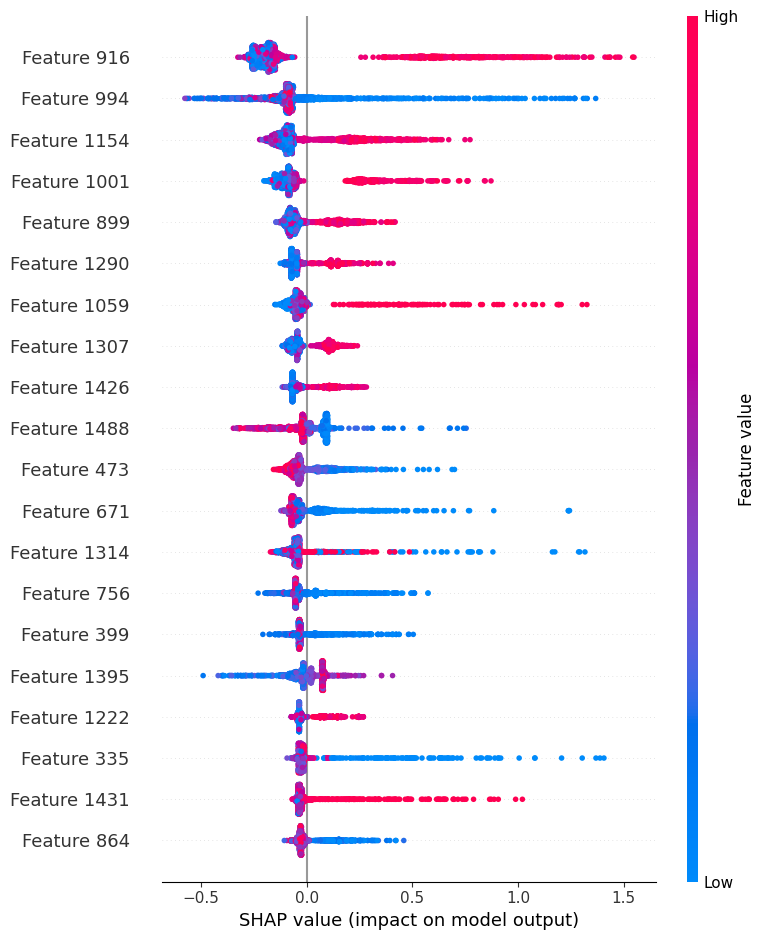

In [44]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor  
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap

# 🚀 Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 🚀 Define models with fixed random_state
models = {
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),  
    "LGBM": LGBMRegressor(random_state=42)
}

# 🚀 Define hyperparameter grids
param_grids = {
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False]
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [10, 20, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [3, 4, 5],
        "min_child_weight": [1, 3, 5],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0]
    },
    "CatBoost": {
        "iterations": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "depth": [4, 6, 8],
        "l2_leaf_reg": [1, 3, 5]
    },
    "LGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.05, 0.1, 0.2],
        "max_depth": [-1, 5, 10],  
        "num_leaves": [20, 31, 40],
        "min_child_samples": [5, 10, 20]
    }
}

# 🚀 Store model results
results = []
best_models = {}

# 🚀 Perform Randomized Search
for name, model in models.items():
    print(f"🔍 Optimizing {name}...")

    if name in param_grids and param_grids[name]:  # Ensure grid exists
        search = RandomizedSearchCV(
            model, param_distributions=param_grids[name], 
            n_iter=10, cv=5, scoring="neg_mean_squared_error", n_jobs=-1, random_state=42
        )
        search.fit(X_train_pca, y_train)
        best_model = search.best_estimator_
        best_params = search.best_params_
    else:
        model.fit(X_train_pca, y_train)
        best_model = model
        best_params = "Default"

    # Store best model
    best_models[name] = best_model

    # 🚀 Evaluate model
    y_pred = best_model.predict(X_test_pca)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        "Model": name,
        "Best Parameters": best_params,
        "Optimized MSE": mse,
        "Optimized RMSE": rmse,
        "Optimized MAE": mae,
        "R2 Score": r2
    })

# 🚀 Convert results to DataFrame
results_df = pd.DataFrame(results)

# 🚀 Display results
print("\n🏆 Model Performance Comparison:")
print(results_df)

# 🚀 Feature Importance Analysis (SHAP for XGBoost)
best_xgb = best_models["XGBoost"]
explainer = shap.Explainer(best_xgb, X_train_pca)
shap_values = explainer(X_train_pca)

# 🚀 Plot SHAP summary
shap.summary_plot(shap_values, X_train_pca)


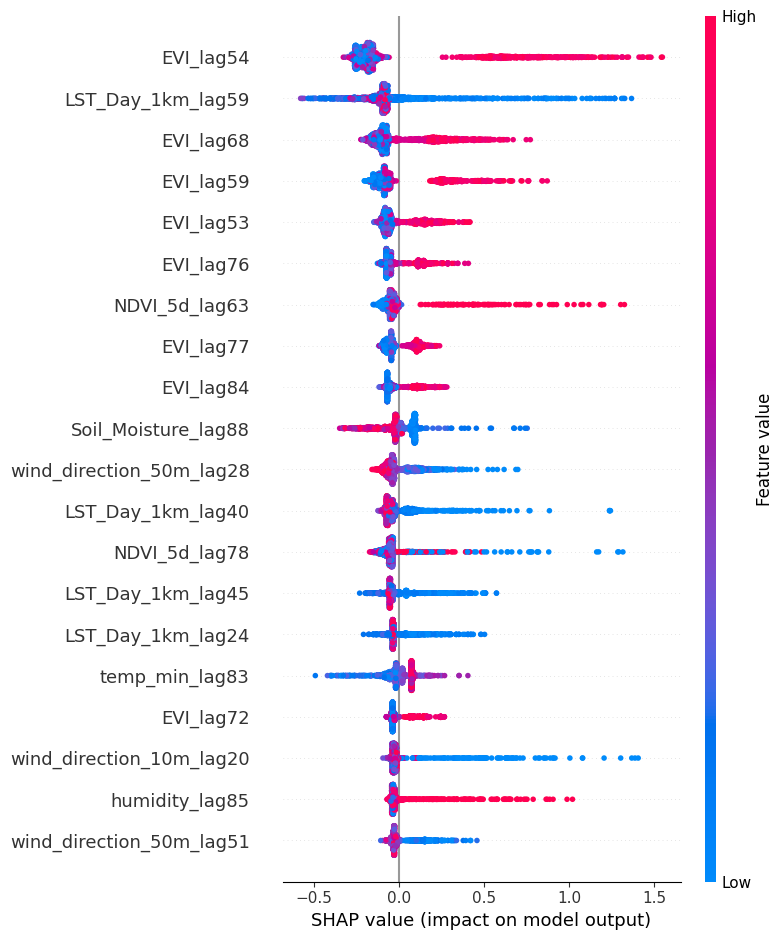

In [55]:
# Ensure feature names are preserved
feature_names = X.columns  # Get original feature names
X_train_pca_df = pd.DataFrame(X_train_pca, columns=feature_names)  # Assign names

# Re-run SHAP with correct names
explainer = shap.Explainer(best_xgb, X_train_pca_df)
shap_values = explainer(X_train_pca_df)

# Plot with correct feature names
plt.figure(figsize=(10, 6))  # Adjust figure size if needed
shap.summary_plot(shap_values, X_train_pca_df)


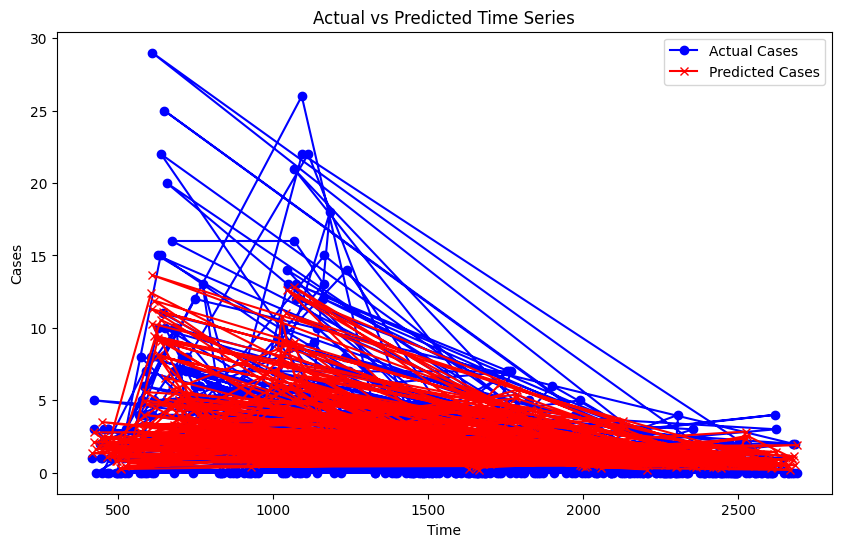

In [60]:
# Plotting Actual vs Predicted Time Series
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test, label='Actual Cases', color='blue', linestyle='-', marker='o')
plt.plot(y_test.index, y_pred_xgb, label='Predicted Cases', color='red', linestyle='-', marker='x')
plt.xlabel("Time")
plt.ylabel("Cases")
plt.title("Actual vs Predicted Time Series")
plt.legend()
plt.show()


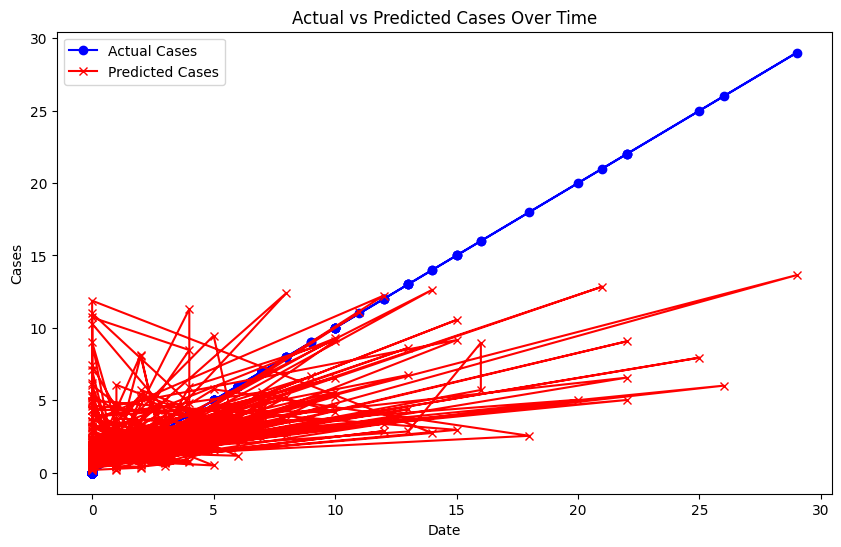

In [62]:
# Assuming y_test has the date index
plt.figure(figsize=(10, 6))

# Plot the actual cases
plt.plot(y_test, y_test, label='Actual Cases', color='blue', linestyle='-', marker='o')

# Plot the predicted cases
plt.plot(y_test, y_pred_xgb, label='Predicted Cases', color='red', linestyle='-', marker='x')

# Labeling the axes and the plot title
plt.xlabel("Date")
plt.ylabel("Cases")
plt.title("Actual vs Predicted Cases Over Time")

# Adding a legend to distinguish between actual and predicted cases
plt.legend()

# Display the plot
plt.show()
